In [32]:
import geopandas
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

import matplotlib.ticker as mtick

import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go

## Importing county level data

  STATEFP  COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD  \
0      31        39  00835841  31039     Cuming     Cuming County   06   
1      53        69  01513275  53069  Wahkiakum  Wahkiakum County   06   
2      35        11  00933054  35011    De Baca    De Baca County   06   
3      31       109  00835876  31109  Lancaster  Lancaster County   06   
4      31       129  00835886  31129   Nuckolls   Nuckolls County   06   

  CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER  \
0      H1  G4020  None   None     None        A  1477652222  10690952   
1      H1  G4020  None   None     None        A   680962890  61582307   
2      H1  G4020  None   None     None        A  6016819475  29089486   
3      H1  G4020   339  30700     None        A  2169270569  22849484   
4      H1  G4020  None   None     None        A  1489645188   1718484   

      INTPTLAT      INTPTLON  \
0  +41.9158651  -096.7885168   
1  +46.2946377  -123.4244583   
2  +34.3592729  -104

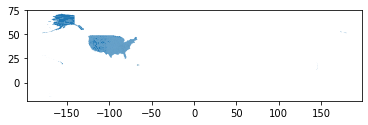

In [2]:
source = 'source data/us county shapefile/tl_2019_us_county.shp'

county = geopandas.read_file(source)
county['COUNTYFP'] = county['COUNTYFP'].astype(int)
county['GEOID'] = county['GEOID'].astype(int)

print(county.head())
county.plot()

The following block of code looks for data that cannot be matched from shapefiles to voter results.

In [3]:
source = 'source data/county presidential results/countypres_2000-2016.csv'
county_vote = pd.read_csv(source).dropna(subset=['FIPS'])
county_vote['FIPS'] = county_vote['FIPS'].astype(int)
cv_voi = ['party','candidatevotes','totalvotes','FIPS']

mask = county_vote['year'] == 2016
c2016 = county_vote[mask].fillna(
    {'party':'na','candidatevotes':0}).pivot_table(values='candidatevotes',columns='party',index='FIPS')

vote_cols = c2016.columns
c2016 = c2016.reset_index().rename(columns={'FIPS':'GEOID'})
c2016

party,GEOID,democrat,na,republican
0,1001,5936.0,865.0,18172.0
1,1003,18458.0,3874.0,72883.0
2,1005,4871.0,144.0,5454.0
3,1007,1874.0,207.0,6738.0
4,1009,2156.0,573.0,22859.0
...,...,...,...,...
3150,56037,3231.0,1745.0,12154.0
3151,56039,7314.0,1392.0,3921.0
3152,56041,1202.0,1114.0,6154.0
3153,56043,532.0,371.0,2911.0


In [4]:
cdf2016=county[['GEOID','geometry']].merge(c2016,on='GEOID')
cdf2016['r/(rd)'] = cdf2016['republican'] / (cdf2016['republican']+cdf2016['democrat'])
cdf2016

,GEOID,geometry,democrat,na,republican,r/(rd)
0,31039,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",719.0,233.0,3122.0,0.812809
1,53069,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",832.0,182.0,1344.0,0.617647
2,35011,"POLYGON ((-104.56739 33.99757, -104.56772 33.9...",193.0,97.0,620.0,0.762608
3,31109,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",61898.0,12737.0,61588.0,0.498745
4,31129,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",353.0,126.0,1726.0,0.830207
...,...,...,...,...,...,...
3109,13123,"POLYGON ((-84.65478 34.66559, -84.65488 34.669...",1965.0,331.0,10477.0,0.842067
3110,27135,"POLYGON ((-96.40466 48.80528, -96.40467 48.813...",1856.0,497.0,5451.0,0.745997
3111,28089,"POLYGON ((-90.09363 32.70763, -90.09360 32.707...",20343.0,1194.0,28265.0,0.581489
3112,48227,"POLYGON ((-101.69227 32.27106, -101.69221 32.2...",1770.0,316.0,6637.0,0.789461


This map is a logical check to see who won.

<Figure size 432x288 with 0 Axes>

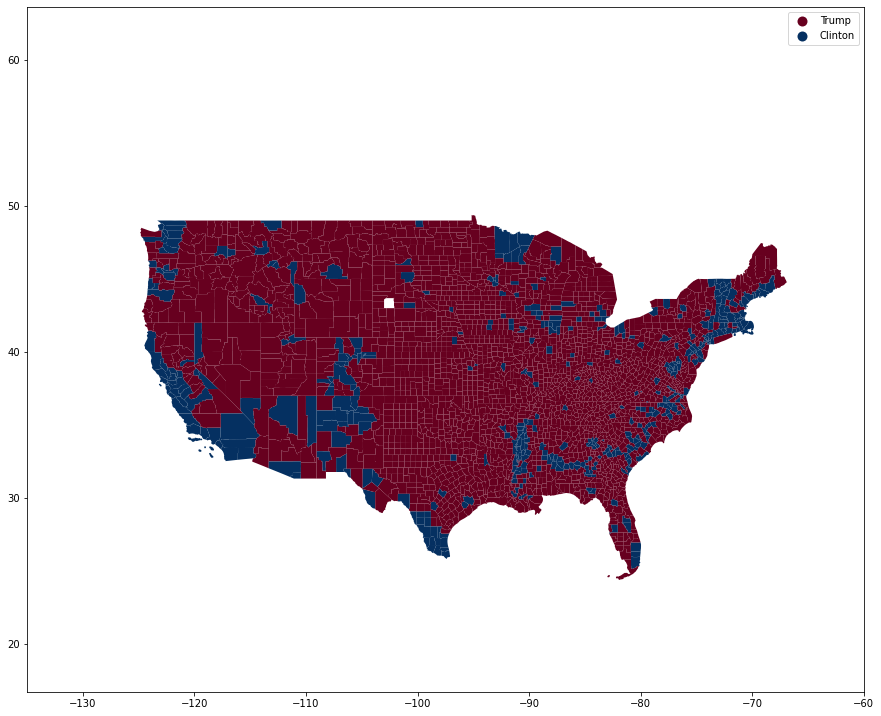

In [5]:
mask = (cdf2016['republican'] > cdf2016['democrat']) & (cdf2016['republican'] > cdf2016['na'])
cdf2016.loc[mask,'color'] = 'Trump'

mask = (cdf2016['democrat'] > cdf2016['republican']) & (cdf2016['democrat'] > cdf2016['na'])
cdf2016.loc[mask,'color'] = 'Clinton'

plt.figure()

f,ax = plt.subplots(1,1)

f.set_figheight(15)
f.set_figwidth(15)

ax.set_xlim(-135,-60)
cdf2016.plot(column='color',ax=ax,
             legend=True,cmap='RdBu',
             categories=['Trump','Clinton']
            )


Visually, this map looks similar to the NY times map. With the exception of Oglala county South Dakota which for some reason didn't get plotted. Also, the US census map I used includes county ownership of parts of lake Michigan. I'm assuming there are no mailboxes on the lake. For this reason, I will need to use Census data regarding population density. I will not be able to calculate population density using the shapefiles.

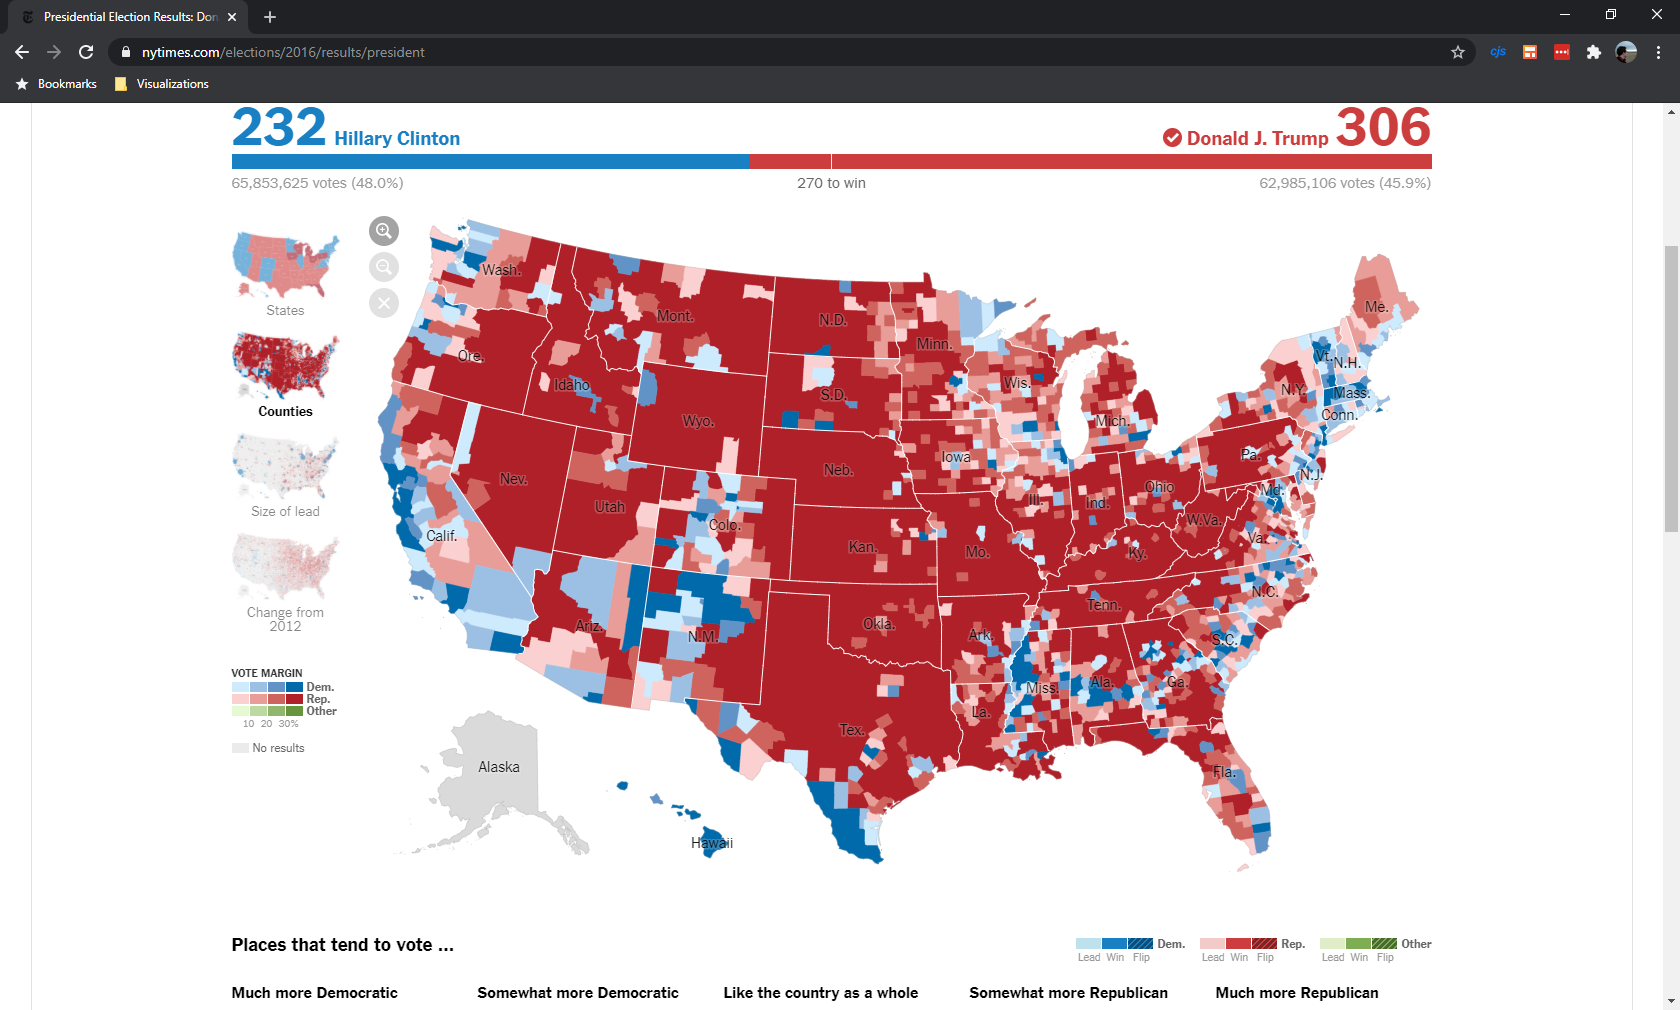

## Importing removed mailbox locations

This is based on analysis done by Nathaniel Story and available on [GitHub](https://github.com/nstory/collection_boxes).

5


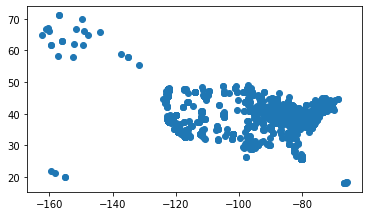

In [6]:
removed = pd.read_csv('source data/removed_2019_to_2020.csv')
mask = removed[['LONGITUDE','LATITUDE']].isna().any(axis=1)
print(mask.sum())
removed = removed[~mask].reset_index(drop=True)

removed = geopandas.GeoDataFrame(
    removed, geometry=geopandas.points_from_xy(removed['LONGITUDE'], removed['LATITUDE']))

removed['net'] = -1
removed.plot()

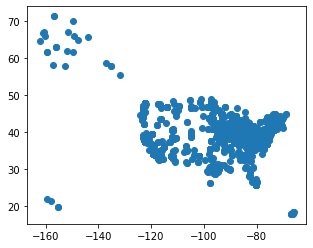

In [7]:
res_r = geopandas.sjoin(
    left_df=cdf2016[['GEOID','r/(rd)','geometry']],
    right_df=removed[['net','geometry']].set_crs("EPSG:4269"),
    how='right',op='contains'
)

res_r.plot()

In [8]:
res_r['r/(rd)'].isna().sum()

30

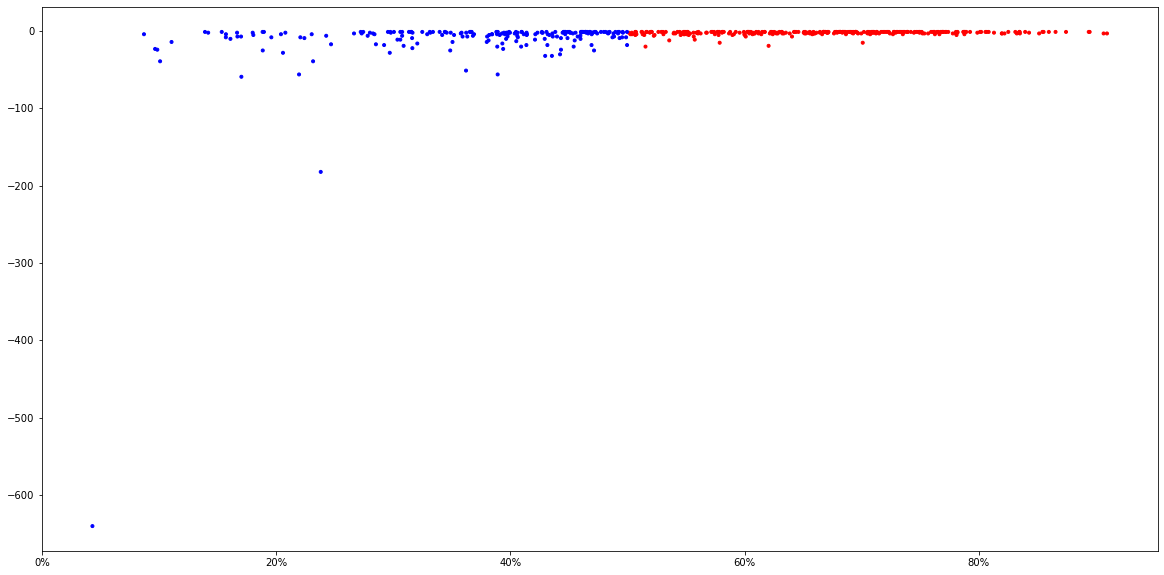

In [9]:
def plot_group(tdf:pd.DataFrame)->plt.figure:
    '''This accepts a dataframe formatted like res, then plots it.'''
    to_plot = tdf.groupby('GEOID').agg({'net':'sum','r/(rd)':'mean'})
    to_plot.sort_values('net')
    
    mask = to_plot['r/(rd)'] <.5
    to_plot.loc[mask,'color'] = 'b'
    to_plot.loc[~mask,'color'] = 'r'
    f,ax=plt.subplots(1,1)
    
    f.set_figheight(10)
    f.set_figwidth(20)
    
    ax.scatter(
        to_plot['r/(rd)']*100,
        to_plot['net'],
        color=to_plot['color'],
        marker='.'
        
    )
    
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.show()
    
plot_group(res_r)

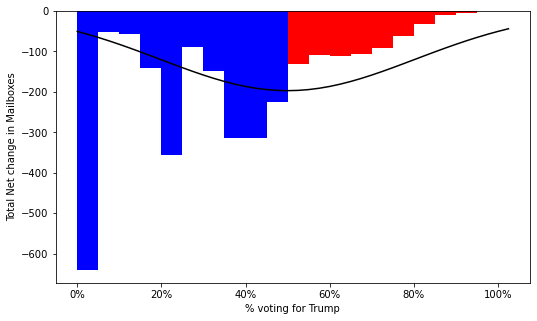

In [10]:
def plot_hist(tdf:pd.DataFrame,step:float=.05)->plt.figure:
    '''This accepts a dataframe formatted like res, then plots it.'''
    x = np.arange(0, 1.0+step, step)
    to_plot = tdf.groupby(
        pd.cut(tdf["r/(rd)"], x)
    )['net'].sum().reset_index()
    
    
    #return to_plot
    to_plot['bin'] = to_plot['r/(rd)'].apply(lambda x:x.left)
    
    #return to_plot
    mask = to_plot['bin'] <.5
    
    to_plot['bin'] = to_plot['bin'].apply(lambda x:float(x) + (step/2))
    to_plot.loc[mask,'color'] = 'b'
    to_plot.loc[~mask,'color'] = 'r'
    f,ax=plt.subplots(1,1)
    
    f.set_figheight(5)
    f.set_figwidth(8.5)
    
    ax.bar(
        x=to_plot['bin'].astype(float)*100,
        height=to_plot['net'],
        color=to_plot['color'],
        width=step*100
    )
    ax.set_xlabel('% voting for Trump')
    ax.set_ylabel('Total Net change in Mailboxes')
    
    # Plot normal
    mu = .5
    x = np.arange(0, 1.0+step, step/2)
    variance = np.var(x)
    sigma = math.sqrt(variance)
    ax.plot(x*100, stats.norm.pdf(x, mu, sigma)*np.mean(to_plot['net']),color='k')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    
plot_hist(res_r)
plt.savefig('total change')

The following code performs the same steps with the data about added mailboxes.

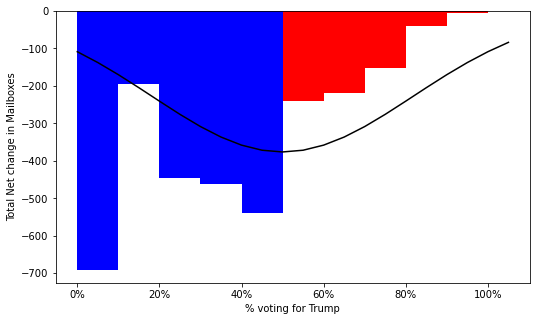

In [11]:

plot_hist(res_r,step=.1)

0


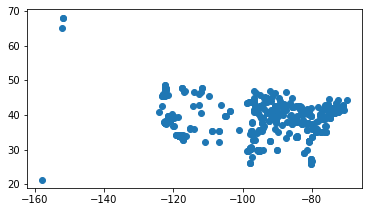

In [12]:
added = pd.read_csv('source data/added_2019_to_2020.csv')
mask = added[['LONGITUDE','LATITUDE']].isna().any(axis=1)
print(mask.sum())
added = added[~mask].reset_index(drop=True)

added = geopandas.GeoDataFrame(
    added, geometry=geopandas.points_from_xy(added['LONGITUDE'], added['LATITUDE']))

added['net'] = 1 # Shows number added
added.plot()

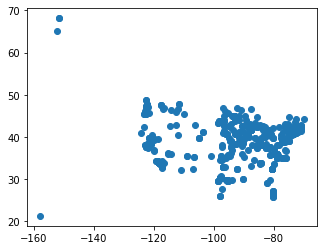

In [13]:
res_a = geopandas.sjoin(
    left_df=cdf2016[['GEOID','r/(rd)','geometry']],
    right_df=added[['net','geometry']].set_crs("EPSG:4269"),
    how='right',op='contains'
)

res_a.plot()

In [14]:
res_a['r/(rd)'].isna().sum()

3

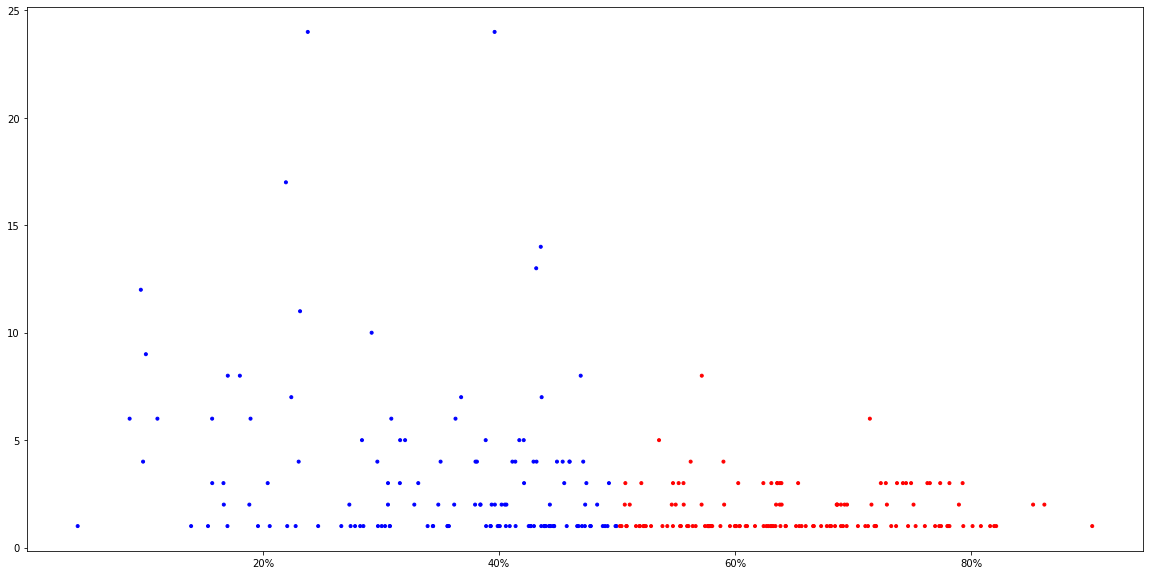

In [15]:
plot_group(res_a)

There is more activity in the blue counties. Let's aggregate to display net change.

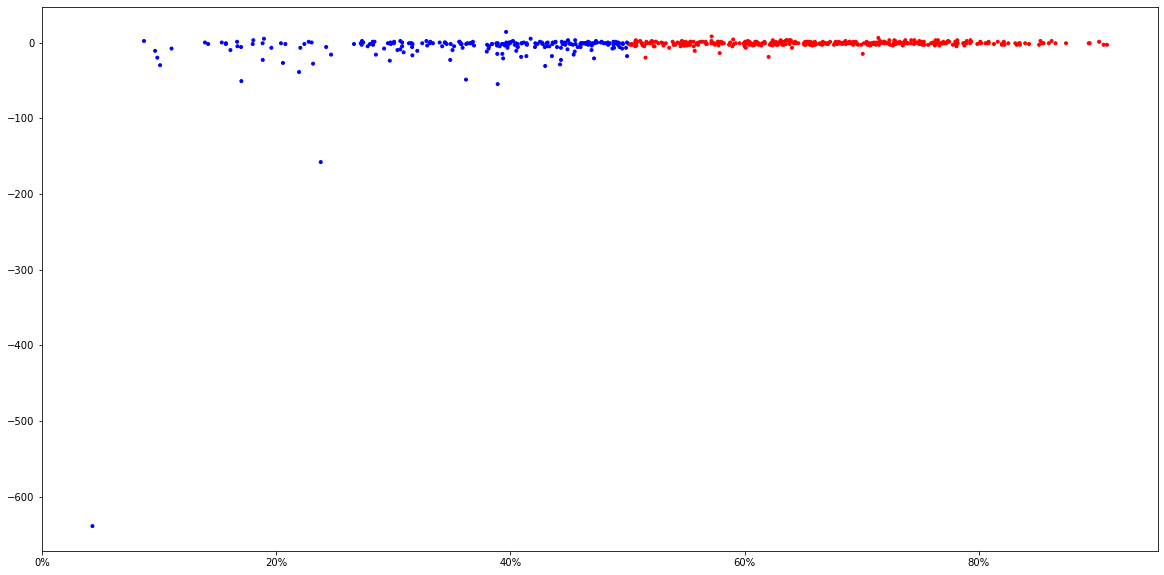

In [16]:
net = pd.concat((res_a,res_r))
plot_group(net)

## Percent change in mailboxes

Import and ingest the number of mailboxes per county as of 2019.

In [17]:
source = './source data/foia_2019-09-27/coll report (reformat).xlsx'

# Note I had to open the original excel file then save as to get pandas to read it correctly.
# When opening the original file, I received an XLRD format unsupported error.I made no change
# or modification to the data.

19


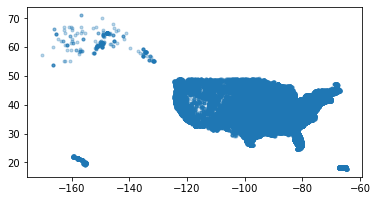

In [18]:
total = pd.read_excel(source)
mask = total[['LONGITUDE','LATITUDE']].isna().any(axis=1)
print(mask.sum())
total.dropna(subset=['LATITUDE','LONGITUDE'],inplace=True)

total = geopandas.GeoDataFrame(
    total, geometry=geopandas.points_from_xy(total['LONGITUDE'], total['LATITUDE']))

total['total_boxes'] = 1
total.plot(marker='.',alpha=.3)

In [19]:
tot_geoid = geopandas.sjoin(
    left_df=cdf2016[['GEOID','r/(rd)','geometry']],
    right_df=total[['total_boxes','geometry']].set_crs("EPSG:4269"),
    how='right',op='contains'
)


tot_geoid = tot_geoid.groupby('GEOID').agg(
        {'r/(rd)':'mean','total_boxes':'sum'}
    ).reset_index().merge(
    net.groupby('GEOID')['net'].sum().reset_index(),
    on='GEOID'
    
)
tot_geoid

,GEOID,r/(rd),total_boxes,net
0,1073.0,0.462102,464,-1
1,1089.0,0.587625,145,0
2,1101.0,0.365942,162,-1
3,1103.0,0.769101,52,-1
4,1125.0,0.600403,122,1
...,...,...,...,...
605,55131.0,0.712678,74,-2
606,55133.0,0.642794,248,0
607,55139.0,0.539713,114,-2
608,56025.0,0.781705,62,-1


In [20]:
tot_geoid['Percent Change'] = tot_geoid['net']/tot_geoid['total_boxes']

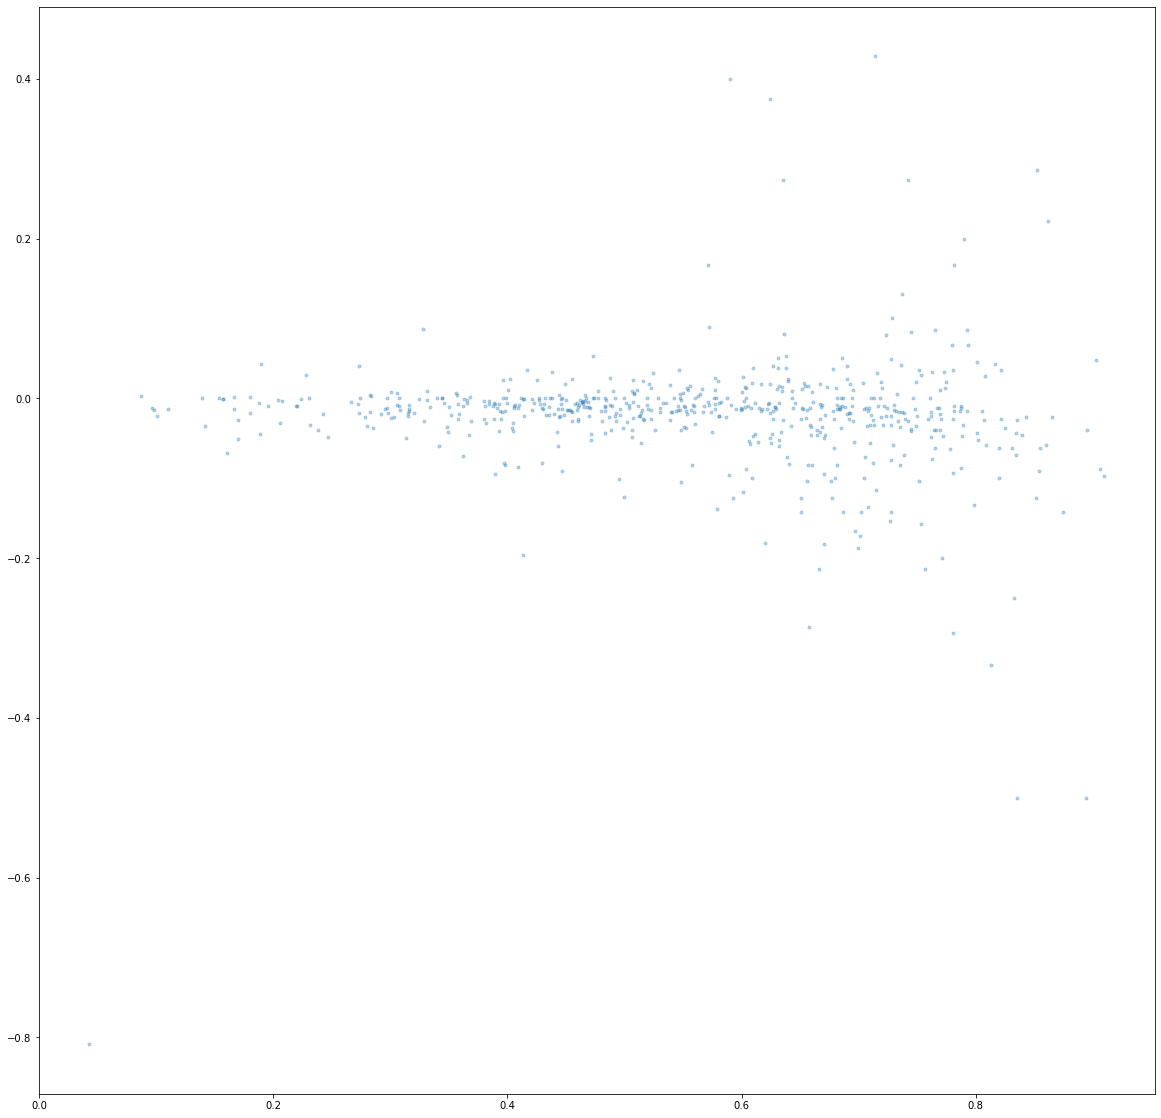

In [21]:
tot_geoid

f,ax = plt.subplots(1,1)

f.set_figwidth(20)
f.set_figheight(20)

ax.scatter(
    y=tot_geoid['Percent Change'],
    x=tot_geoid['r/(rd)'],
    marker='.',
    alpha=.3
)

plt.show()

In [22]:
tot_geoid.sort_values('Percent Change')

,GEOID,r/(rd),total_boxes,net,Percent Change
56,11001.0,0.043048,790,-639,-0.808861
400,38087.0,0.893827,2,-1,-0.500000
318,32009.0,0.835025,6,-3,-0.500000
295,30019.0,0.812918,6,-2,-0.333333
534,49055.0,0.780922,17,-5,-0.294118
...,...,...,...,...,...
493,46079.0,0.635705,11,3,0.272727
312,31105.0,0.852564,7,2,0.285714
496,46101.0,0.624009,8,3,0.375000
389,37103.0,0.590196,10,4,0.400000


In [23]:
county[county['GEOID']==11001]

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
631,11,1,01702382,11001,District of Columbia,District of Columbia,00,H6,G4020,548,47900,47894,F,158340389,18687196,+38.9042474,-077.0165167,"POLYGON ((-77.11975 38.93435, -77.11886 38.935..."


In [24]:
c2016[c2016['GEOID']==11001]

party,GEOID,democrat,na,republican
331,11001,282830.0,15715.0,12723.0


The following block of code groups by level of Trump support, then calculates the percent change.

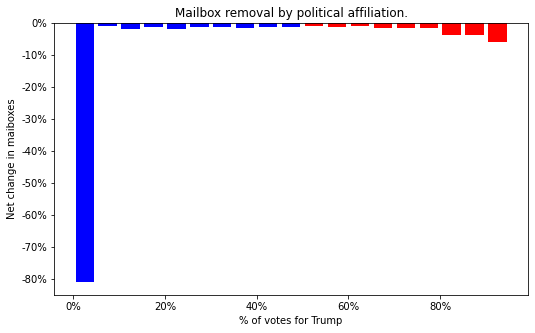

In [25]:
def per_change(tdf,step:float=.05,ax=None,title='Mailbox removal by political affiliation.'):
    '''Accepts a dataframe with total number of mailboxes and the net change.
    Then it bins based on Trump support and plots.'''
    
    x = np.arange(0, 1.0+step, step)
    to_plot = tdf.groupby(
        pd.cut(tdf["r/(rd)"], x)
    )[['net','total_boxes']].sum().reset_index().fillna({'Percent Change':0})
    
    
    to_plot['bin'] = to_plot['r/(rd)'].apply(lambda x:(x.left + (step/2))*100)
    to_plot['Percent Change'] = to_plot['net']/to_plot['total_boxes']
    
    mask = to_plot['bin'].astype(float)<50
    to_plot.loc[mask,'color']='b'
    to_plot.loc[~mask,'color']='r'
    
    if ax is None:
        f,ax=plt.subplots(1,1)
        
    ax.bar(to_plot['bin'],
           to_plot['Percent Change']*100,
           width=4,color=to_plot['color'])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_title(title)
    ax.set_xlabel('% of votes for Trump')
    ax.set_ylabel('Net change in maiboxes')
    return to_plot

f,ax=plt.subplots(1,1)
f.set_figwidth(8.5)
f.set_figheight(5)
per_change(tot_geoid,ax=ax)

plt.savefig('percent_w_DC')

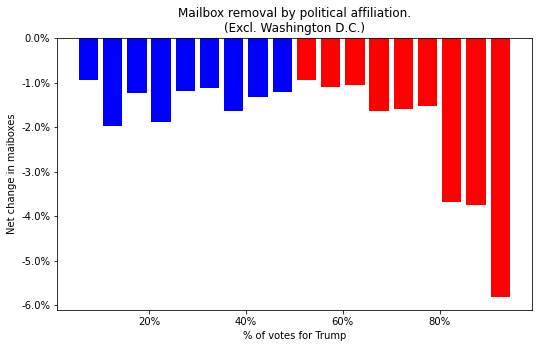

In [26]:
mask = tot_geoid['GEOID'] != 11001.0


f,ax=plt.subplots(1,1)
f.set_figwidth(8.5)
f.set_figheight(5)
per_change(tot_geoid[mask],title='Mailbox removal by political affiliation.\n(Excl. Washington D.C.)',ax=ax)
plt.savefig('removal excl DC')

## Population data

In [27]:
path = './source data/County Census - data.census/'
path += 'ACSDT5Y2018.B01003_data_with_overlays_2020-08-31T002447.csv'

acs = pd.read_csv(path,header=1)

acs.dropna(subset=['id'],inplace=True)

acs['GEOID'] = acs['id'].str.extract(r'US(\d*)').astype(int)
acs.rename(columns={'Estimate!!Total':'Population'},inplace=True)

acs = acs[['Population','GEOID']].merge(
    tot_geoid,
    on='GEOID',
    how='right'
)


acs

,Population,GEOID,r/(rd),total_boxes,net,Percent Change
0,659892,1073,0.462102,464,-1,-0.002155
1,357560,1089,0.587625,145,0,0.000000
2,226941,1101,0.365942,162,-1,-0.006173
3,119122,1103,0.769101,52,-1,-0.019231
4,206213,1125,0.600403,122,1,0.008197
...,...,...,...,...,...,...
605,80610,56025,0.781705,62,-1,-0.016129
606,23059,56039,0.348999,47,-2,-0.042553
607,1753,30019,0.812918,6,-2,-0.333333
608,981,32009,0.835025,6,-3,-0.500000


In [37]:
fig = px.scatter(
    data_frame=acs,
    x='Population',
    y='total_boxes',
    color='r/(rd)',
    log_x=True,
    log_y=True
)

fig.show()

In [52]:
acs['Box per capita'] = acs['total_boxes']/acs['Population']
mask = acs['Percent Change'] > -.5

fig = px.scatter(
    data_frame=acs[mask],
    x='r/(rd)',
    y='Box per capita',
    color='Percent Change'
)

fig.show()